# Домашнее задание по теме: Регрессия (линейная/полиномиальная)

## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install pandas matplotlib numpy seaborn scikit-learn -y

## **ВНИМАНИЕ**

- **Задания описаны кратко, только самое необходимое, в основном только идеи и подсказки. Это творческая работа.**

- Для выполнения заданий можно использовать любые удобные способы, если в комментариях к заданию не указан конкретный метод. 

- Желательно использовать максимум пройденной информации или более продвинутые способы (если нашли самостоятельно).

- Желательно писать свои идеи/мысли по поводу методов/результатов.

- В строке "Подсказка" могут быть перечислены какие-то методы, которыми можно воспользоваться, но это не обязательно, так как это только один из множества вариантов (не факт, что лучший).

- Можно использовать `Pipeline`, но не обязательно.

- Графики можно рисовать любым способом / цветом и т.п. Главное, чтобы было понятно, что там изображено.

- При выполнении задания необходимо понимать, что значит каждое слово (на английском). Если значение слова непонятно, то необходимо разобраться с его значением самостоятельно. Пожалуйста, будьте внимательны, перепроверяйте значения слов, если не уверены.

## Импорт необходимых пакетов

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


## Загрузка данных

[Источник (Medical Cost Personal Datasets)](https://www.kaggle.com/mirichoi0218/insurance)

In [168]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Преобразование типов

Привести в порядок типы данных. В результате не должно быть типа `object`.

In [169]:
df_new = df
df_new["is_smoker"] = df.smoker.map({'yes': True, 'no': False})
df_new["is_male"] = df.sex.map({'male': True, 'female': False})
dummies = pd.get_dummies(df[['region']])
df_new = df.join(dummies)

df_new.drop(['smoker','sex','region'], axis = 1, inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   is_smoker         1338 non-null   bool   
 5   is_male           1338 non-null   bool   
 6   region_northeast  1338 non-null   uint8  
 7   region_northwest  1338 non-null   uint8  
 8   region_southeast  1338 non-null   uint8  
 9   region_southwest  1338 non-null   uint8  
dtypes: bool(2), float64(2), int64(2), uint8(4)
memory usage: 49.8 KB


## Разделить на train/test

- Разделить данные на `y` и `X`. 
- `y` - это колонка `charges`.
- Разделить данные на train / test.
- **В дальнейшем при анализе использовать строго `train` данные и не подсматривать в `test`.**

In [170]:
from sklearn.model_selection import train_test_split

y = df_new[['charges']].copy()
X = df_new[['is_smoker']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Выбросы

- Есть ли выбросы? Каково распределение данных?
    - `hist`
    - `kde`
    - `boxplot`
- Нужно ли с этим что-то делать?

<AxesSubplot:>

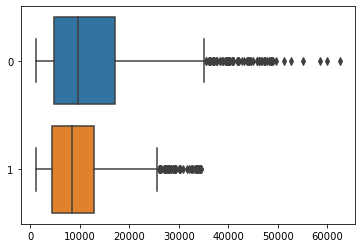

In [171]:
import scipy
from scipy import stats

df_train = X_train.join(y_train)
charges_with = df_train['charges']         
        
z = stats.zscore(charges_with)
z_abs = np.abs(z)
z_threshold = 3
charges_without_z = charges_with[z_abs < z_threshold]
charges_without_z

df_train['charges_new'] = charges_without_z 
df_train.dropna(inplace=True)

X_train = pd.DataFrame(df_train.is_smoker)
y_train = pd.DataFrame(df_train.charges)

len(charges_with) - len(charges_without_iqr)
sns.boxplot(data=[charges_with, charges_without_iqr], orient='h')

## Анализ корреляций

- Проверить нет ли мультиколлинеарности.
- Если есть, то нужно ли что-то с этим делать?

Подсказка: в `sns.heatmap` можно указать параметры `vmin`, `vmax` для более адекватного распределения цвета.

<AxesSubplot:>

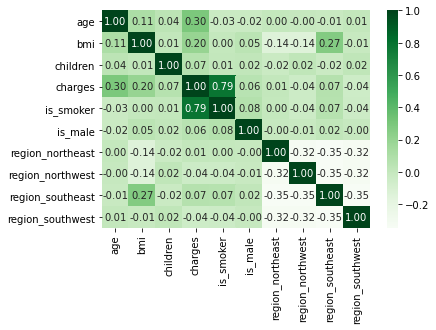

In [172]:
corr = df_new.corr()
sns.heatmap(corr, 
            cmap="Greens", 
            annot=True, 
            annot_kws={"size": 10}, 
            fmt="1.2f")

#Есть сильная зависимость между КУРЕНИЕМ и СУММОЙ СТРАХОВКИ

## Простая линейная регрессия

Пока что используется только **один признак**. Для этого в метод `fit` в качестве `X` можно передать `X_train[[col_name]]`, аналогично с тестовыми данными.

- Если необходимо, то использовать методы feature engineering. 
- Помнить о том, что может быть полезна нормализация/стандартизация.
- Обучить модель простой линейной регрессии.
- Проанализировать результаты (различные метрики). Написать выводы/идеи.
- Нарисовать график.

Подсказка: если не используется `Pipeline`, то важно не забыть применить все преобразования, которые были выполнены над трейновыми данными, к тестовым данным.

Coefficients:  [[22383.10397711]]
Intercept:  [8510.52765284]
R2: 0.605262978967557
MSE: 53153149.74206293
Variance score: 0.6367164576847731
Residual sum of squares: charges    5.323726e+07
dtype: float64
R2 (train): 0.605262978967557
R2 (test): 0.6367164576847731
MSE (train): 53153149.74206293
MSE (test): 53237261.706976816


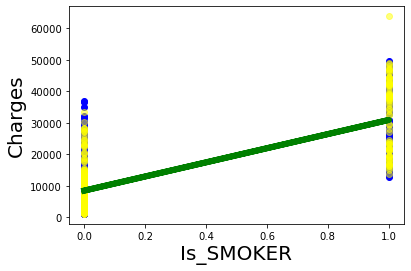

In [173]:
# импортировать из пакета с моделями модель линейной регрессии
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# создать объект линейной регрессии
simple_regr = linear_model.LinearRegression()

# обучить модель
simple_regr.fit(X_train, y_train)

# вывести результаты обучения
print('Coefficients: ', simple_regr.coef_)
print('Intercept: ',simple_regr.intercept_)

y_train_predicted = simple_regr.predict(X_train)
print(f'R2: {r2_score(y_train, y_train_predicted)}')
print(f"MSE: {mean_squared_error(y_train, y_train_predicted, squared=True)}")

plt.scatter(X_train, y_train,  color='blue')
plt.scatter(X_test, y_test,  color='yellow', alpha=0.5)

plt.plot(X_train, 
         # simple_regr.predict(X_train[['age']]) =
         simple_regr.coef_[0]*X_train + simple_regr.intercept_, 
         '-g', 
         linewidth=6)
plt.xlabel("Is_SMOKER", fontsize=20)
plt.ylabel("Charges", fontsize=20)


# использовать обученную модель для предсказания на test выборке
y_test_predicted = simple_regr.predict(X_test)

y_test_predicted

# вывести результаты предсказания
print(f'Variance score: {simple_regr.score(X_test, y_test)}')    # Coefficient of determination R^2 of the prediction
print(f"Residual sum of squares: {np.mean((y_test_predicted - y_test) ** 2)}")    # MSE

r2_score(y_true=y_test, y_pred=y_test_predicted)    # эквивалентно simple_regr.score(X_test, y_test)

# MSE
mean_squared_error(y_true=y_test, y_pred=y_test_predicted, squared=True)   # эквивалентно np.mean((y_test_predicted - y_test) ** 2)

print(f'R2 (train): {r2_score(y_train, y_train_predicted)}')
print(f'R2 (test): {r2_score(y_test, y_test_predicted)}')

print(f"MSE (train): {mean_squared_error(y_train, y_train_predicted, squared=True)}")
print(f"MSE (test): {mean_squared_error(y_test, y_test_predicted, squared=True)}")


## Множественная линейная регрессия

Можно использовать любое количество признаков.

- Если необходимо, то использовать методы feature engineering.
- Помнить о том, что может быть полезна нормализация/стандартизация.
- Обучить модель линейной регрессии.
- Проанализировать результаты (различные метрики).

Подсказка: если не используется `Pipeline`, то важно не забыть применить все преобразования, которые были выполнены над трейновыми данными, к тестовым данным.

In [201]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = df_new[['charges']].copy()
X = df_new[['is_smoker','age','bmi','children','is_male','region_northeast','region_northwest','region_southeast','region_southwest']].copy()
#X = df_new[['is_smoker','age','bmi','children','is_male']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

simple_regr = linear_model.LinearRegression()
simple_regr.fit(X_train, y_train)

print('Coefficients: ', simple_regr.coef_)
print('Intercept: ',simple_regr.intercept_)

y_train_predicted = simple_regr.predict(X_train)
y_test_predicted = simple_regr.predict(X_test)

print(f'Variance score: {simple_regr.score(X_test, y_test)}')  
print(f"Residual sum of squares: {np.mean((y_test_predicted - y_test) ** 2)}")   

r2_score(y_true=y_test, y_pred=y_test_predicted) 

mean_squared_error(y_true=y_test, y_pred=y_test_predicted, squared=True)

print(f'R2 (train): {r2_score(y_train, y_train_predicted)}')
print(f'R2 (test): {r2_score(y_test, y_test_predicted)}')

print(f"MSE (train): {mean_squared_error(y_train, y_train_predicted, squared=True)}")
print(f"MSE (test): {mean_squared_error(y_test, y_test_predicted, squared=True)}")

Coefficients:  [[23700.98328681   261.56839546   347.09728999   371.76216879
    121.12368626   507.5006912    167.88229534  -378.99888994
   -296.38409659]]
Intercept:  [-12933.71482887]
Variance score: 0.7605492639270062
Residual sum of squares: charges    3.509023e+07
dtype: float64
R2 (train): 0.7456141330086122
R2 (test): 0.7605492639270062
MSE (train): 37268977.76686481
MSE (test): 35090225.72562571


## Полиномиальная множественная регрессия

Можно использовать любое количество признаков.
Попробовать несколько различных степеней полинома.

- Если необходимо, то использовать методы feature engineering.
- Помнить о том, что может быть полезна нормализация/стандартизация.
- Обучить модель линейной регрессии.
- Проанализировать результаты (различные метрики).

Подсказка: 
- Если не используется `Pipeline`, то важно не забыть применить все преобразования, которые были выполнены над трейновыми данными, к тестовым данным.
- Перебор нескольких степеней полинома можно сделать в цикле и аккуратно вывести метрики для каждого варианта.

In [202]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import r2_score

y = df_new[['charges']].copy()
X = df_new[['is_smoker','age','bmi','children','is_male','region_northeast','region_northwest','region_southeast','region_southwest']].copy()
#X = df_new[['is_smoker','age','bmi','children','is_male']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_train_poly

poly_regr = linear_model.LinearRegression()
poly_regr.fit(X_train_poly, y_train)

print('Coefficients: ', poly_regr.coef_)
print('Intercept: ', poly_regr.intercept_)

X_test_poly = poly.transform(X_test)
y_predicted = poly_regr.predict(X_test_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_predicted - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_predicted - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_true=y_test, y_pred=y_predicted))

Coefficients:  [[ 8.97445789e+13 -8.76313082e+03 -4.89602824e+01  5.29938233e+02
   2.11012464e+03 -2.87259270e+01 -9.69020492e+02 -3.36772549e+02
   7.21196716e+02  5.84596326e+02 -8.76313082e+03 -6.91673890e+00
   1.45964673e+03 -5.41679343e+02 -6.61990268e+01 -1.47065138e+03
  -3.04237496e+03 -3.09588700e+03 -1.15421747e+03  3.86177069e+00
   7.90233771e-01 -9.50651161e+00  4.87438242e+00 -3.38179093e+01
  -1.55446268e+01 -6.10214705e+00  6.50440081e+00 -1.02435482e+01
  -1.83518108e+01  7.27462788e+00  2.35841206e+02  1.43897723e+02
   7.74909125e+01  7.27083918e+01 -1.87056143e+02 -6.77969766e+02
   1.13641127e+02  1.03147993e+03  5.19576357e+02  4.45427223e+02
  -2.87259270e+01  1.18378984e+03 -3.58293303e+01  1.56899494e+02
  -1.33358594e+03 -9.69020492e+02  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.36772549e+02  0.00000000e+00  0.00000000e+00
   7.21196716e+02  0.00000000e+00  5.84596326e+02]]
Intercept:  [-8.97445789e+13]
Mean absolute error: 2783.90
Residual sum of 

In [203]:
poly3 = PolynomialFeatures(degree=3)
X_train_poly3 = poly3.fit_transform(X_train)
cubic_regr = linear_model.LinearRegression()
y3_train = cubic_regr.fit(X_train_poly3, y_train)

print ('Coefficients: ', cubic_regr.coef_)
print ('Intercept: ',cubic_regr.intercept_)

test_x_poly3 = poly3.transform(X_test)
y3_predicted = cubic_regr.predict(test_x_poly3)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y3_predicted - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y3_predicted - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_true=y_test, y_pred=y3_predicted))

Coefficients:  [[ 4.78704368e-07 -1.51620116e+04 -6.65645851e+02 -2.08484819e+03
   3.96624601e+03 -3.34417287e+03  1.17207381e+03  2.25256522e+03
  -7.42451061e+02 -2.68218797e+03 -1.51620116e+04  8.18604365e+01
   1.49565637e+03  1.48736327e+02  2.62819775e+03 -2.07355481e+02
  -9.16531675e+03 -1.78560113e+03 -4.00373824e+03  1.58660391e+01
   1.37719825e+01 -1.63531124e+02  2.07165722e+02 -1.81947184e+02
  -1.71612577e+02 -1.57984213e+02 -1.54101878e+02  7.20335233e+01
   8.82024548e+00  6.43270618e+01 -6.37550154e+02 -7.18936098e+02
  -4.76024244e+02 -2.52337692e+02 -7.40901003e+02 -9.83886881e+02
   1.83887688e+03  9.32385300e+02  3.09463959e+02  8.85519871e+02
  -3.34417287e+03 -1.34456666e+03 -1.05802006e+03  4.83839974e+02
  -1.42542613e+03  1.17207381e+03  2.74667400e-10 -6.55518306e-10
  -3.90741661e-10  2.25256522e+03  2.14413376e-10 -2.11457518e-10
  -7.42451061e+02  1.67119651e-11 -2.68218797e+03 -1.51620116e+04
   8.18604365e+01  1.49565637e+03  1.48736327e+02  2.62819775